### articles analysis

In [26]:
import pandas as pd
from urllib.parse import unquote

articles = pd.read_csv('data/wikispeedia_paths-and-graph/articles.tsv', 
                      sep='\t', 
                      comment='#', 
                      header=None,
                      names=['article'])
# unquote the titles
articles = articles.map(unquote)
articles.head()

,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


### categories analysis

In [27]:
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv',
                        sep='\t',
                        comment='#',
                        header=None,
                        names=['article', 'category'])
# unquote 
categories = categories.map(unquote)
categories.head()

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [28]:

nodes = {}
# Process each row to build the nodes
for _, row in categories.iterrows():
    category_parts = row['category'].split('.')
    article = row['article']
    path_parts = category_parts + [article]

    for i, part in enumerate(path_parts):
        node_id = '.'.join(category_parts[:i] + [part])
        parent_id = '.'.join(category_parts[:i]) if i > 0 else ''
        if node_id not in nodes:
            nodes[node_id] = {
                'id': node_id,
                'name': part,
                'parent': parent_id,
                'size': 0
            }
        nodes[node_id]['size'] += 1

nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
# Calculate relative sizes
parent_sizes = nodes_df.set_index('id')['size'].to_dict()
nodes_df['relative_size'] = nodes_df.apply(
    lambda row: (row['size'] / parent_sizes.get(row['parent'], row['size'])) * 100
    if parent_sizes.get(row['parent'], row['size']) else 100,
    axis=1
)

In [29]:
import random
import plotly.graph_objects as go

def create_treemap(ids, labels, parents, values, hover_text):

    # generate random deep colors
    colors = [f"#{random.randint(30, 150):02x}{random.randint(30, 150):02x}{random.randint(30, 150):02x}" for _ in ids]

    fig = go.Figure(go.Treemap(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        hovertext=hover_text,
        hoverinfo="text",
        maxdepth=2,
        branchvalues="total",
        marker=dict(colors=colors, line=dict(width=1, color='#000000')),
        textfont=dict(color='white', size=16), 
        textposition="middle center", 
        hoverlabel=dict(bgcolor='#2c3e50', font=dict(color='white'))
    ))

    fig.update_layout(
        width=1000,
        height=800,
        title=dict(
            text="Category-Article Treemap",
            xanchor='center',
            x=0.5,
            yanchor='top',
            font=dict(color='white')
        ),
        paper_bgcolor='#111111',
        plot_bgcolor='#111111',
        font=dict(color='white')
    )

    return fig

In [30]:
ids, parents, values = nodes_df['id'], nodes_df['parent'], nodes_df['size']

# Fill NaN values in relative_size with 0 before rounding
nodes_df['relative_size'] = nodes_df['relative_size'].fillna(0)

labels = nodes_df.apply(
    lambda row: f"{row['name']}" if row['size'] == 1 else f"{row['name']}<br>({row['relative_size']:.2f}%)",
    axis=1
)

hover_text =  nodes_df.apply(
    lambda row: "Article" if row['size'] == 1 else
    f"Full Category: {row['id']}<br>"
    f"Size: {row['size']}<br>"
    f"Percentage: {row['relative_size']:.2f}%",
    axis=1
)
fig = create_treemap(ids, labels, parents, values, hover_text)
fig.show()
fig.write_html("./charts/category-article_treemap.html")


Github preview is not working for this plotly chart. 

Please check here: https://epfl-ada.github.io/ada-2024-project-genshinstart/charts/category-article_treemap.html

### links analysis

In [31]:
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv',
                     sep='\t',
                     comment='#',
                     header=None,
                     names=['from', 'to'])
# unquote
links = links.map(unquote)
links.head()

,from,to
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [32]:
def find_most_detailed_common_category(article1, article2):
    # Get all categories for both articles
    categories1 = categories[categories['article'] == article1]['category'].tolist()
    categories2 = categories[categories['article'] == article2]['category'].tolist()
    
    # Early return if either article has no categories
    if not categories1 or not categories2:
        return None
    
    # Convert categories to sets of all prefixes for efficient lookup
    def get_all_prefixes(category):
        parts = category.split('.')
        return {'.'.join(parts[:i+1]) for i in range(len(parts))}
    
    # Get all possible prefixes for each category
    prefixes1 = {prefix for cat in categories1 for prefix in get_all_prefixes(cat)}
    prefixes2 = {prefix for cat in categories2 for prefix in get_all_prefixes(cat)}
    
    # Find common prefixes
    common_categories = prefixes1.intersection(prefixes2)
    
    if not common_categories:
        return None
        
    # Return the longest common category
    return max(common_categories, key=len)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_category_depths(links_df):
    def count_depth(category):
        if category is None:
            return 0
        return len(category.split('.'))
    
    depths = []
    
    # Analyze each link
    for _, row in links_df.iterrows():
        from_article = row['from']
        to_article = row['to']
        
        # Find the most detailed common category
        common_category = find_most_detailed_common_category( from_article, to_article)
        # Count the depth
        depth = count_depth(common_category)
        depths.append(depth)
    
    # Calculate distribution
    distribution = {}
    for depth in depths:
        distribution[depth] = distribution.get(depth, 0) + 1
        
    return distribution

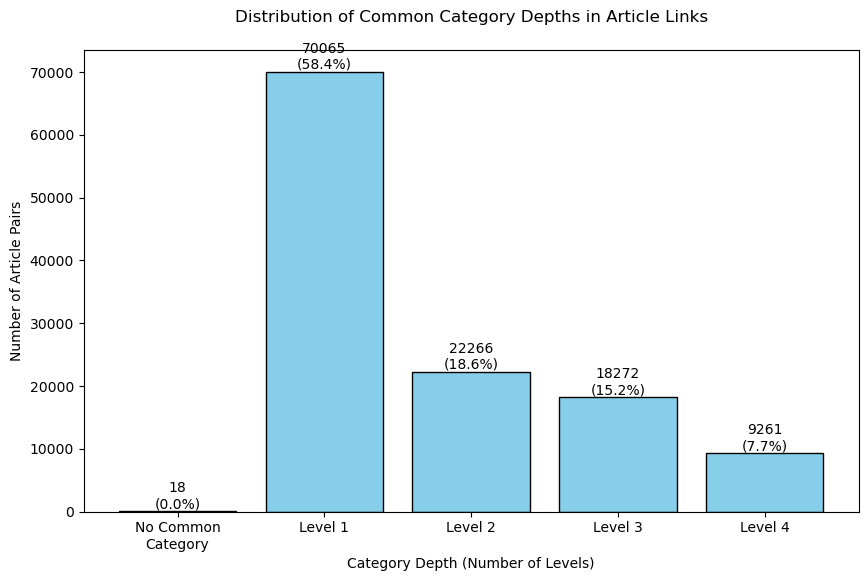

In [34]:
distribution = analyze_category_depths(links)

def plot_category_depth_distribution(distribution):

    plt.figure(figsize=(10, 6))

    # Create bar plot
    depths = list(distribution.keys())
    counts = list(distribution.values())

    plt.bar(depths, counts, color='skyblue', edgecolor='black')

    # Calculate ratios
    total_counts = sum(counts)
    percentages = [(count / total_counts) * 100 for count in counts]

    # Customize plot
    plt.title('Distribution of Common Category Depths in Article Links', pad=20)
    plt.xlabel('Category Depth (Number of Levels)')
    plt.ylabel('Number of Article Pairs')

    # Add value labels on top of each bar
    for i, (count, percent) in enumerate(zip(counts, percentages)):
        plt.text(depths[i], count, f'{count}\n({percent:.1f}%)', 
                ha='center', va='bottom')

    # Set x-axis ticks
    plt.xticks(depths, [f'Level {d}' if d > 0 else 'No Common\nCategory' for d in depths])


    plt.show()
    
plot_category_depth_distribution(distribution)

- We could tell that over half of the links don't share a common category since the level 1 category is 'subject' which is the highest level of category.

### path analysis

In [35]:
def load_and_unquote_paths(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=column_names)
    df['path'] = df['path'].map(unquote)
    return df

paths_finished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_finished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','rating'])
paths_finished.head()


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [36]:
# clean paths by removing back navigation ('<') and corresponding nodes.

cleaned_paths = []

for path in paths_finished['path']:
    nodes = path.split(';')
    stack = []
    
    for node in nodes:
        if node == '<':
            if stack:  
                stack.pop()
        else:
            stack.append(node)
    
    cleaned_path = ';'.join(stack)
    cleaned_paths.append(cleaned_path)

paths_finished['path'] = cleaned_paths

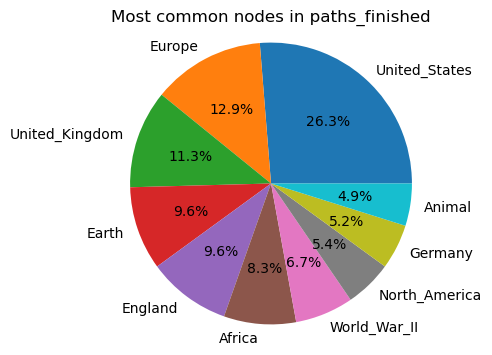

In [37]:
from collections import Counter

all_paths = ';'.join(paths_finished['path'])
nodes = all_paths.split(';')
node_counts = Counter(nodes)

import matplotlib.pyplot as plt

# pie chart of the most common nodes
top_nodes = node_counts.most_common(10)
# split the nodes and counts
nodes, counts = zip(*top_nodes)
plt.figure(figsize=(4,4))
plt.title('Most common nodes in paths_finished')
plt.pie(counts, labels=nodes, autopct='%1.1f%%')
plt.axis('equal')
plt.show()


In [38]:
# find the easiest path
paths_finished['path'].value_counts().head(10)

path
Brain;Computer_science;Information;Communication;Telephone             160
Bird;Fish;Whale_shark;Shark;Great_white_shark                           90
Asteroid;Earth;Europe;Norway;Viking                                     83
Theatre;India;Mammal;Zebra                                              79
Theatre;Dance;Animal;Mammal;Zebra                                       74
Brain;Computer_science;Internet;World_Wide_Web;Telephone                44
Brain;Computer_science;Internet;Information;Communication;Telephone     44
Batman;Scotland;Agriculture;Fossil_fuel;Wood                            38
Brain;Animal;Human;Communication;Telephone                              30
Pyramid;Ancient_Egypt;Cereal;Seed;Bean                                  30
Name: count, dtype: int64

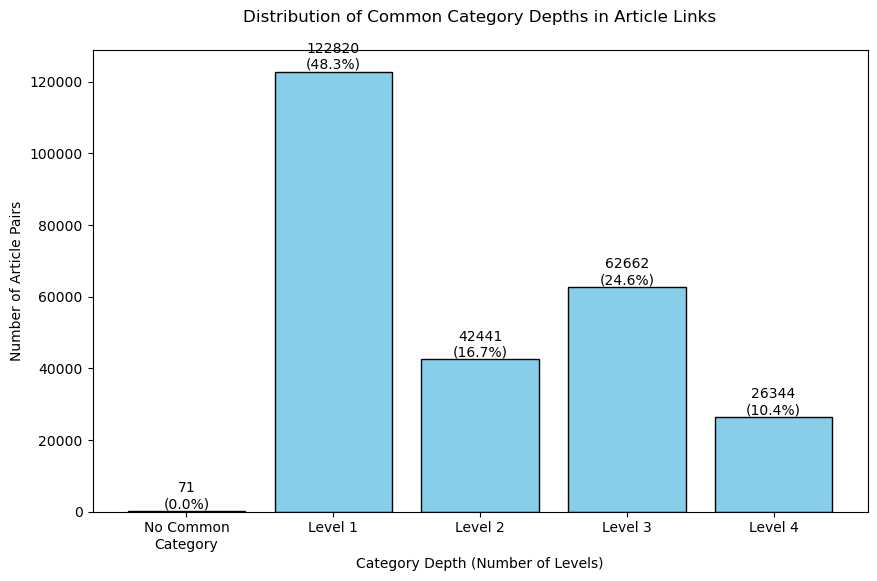

In [39]:
df = pd.DataFrame(columns=['from', 'to'])
rows = []
for path in paths_finished['path']:
    nodes = path.split(';')
    for i in range(len(nodes) - 1):
        rows.append({'from': nodes[i], 'to': nodes[i + 1]})

df = pd.DataFrame(rows)

plot_category_depth_distribution(analyze_category_depths(df))

In the path analysis, we could see that the level of common category between the source and target is rising, which maybe can indicate that if the source and target have more common categories, the path is easier for humans to find.


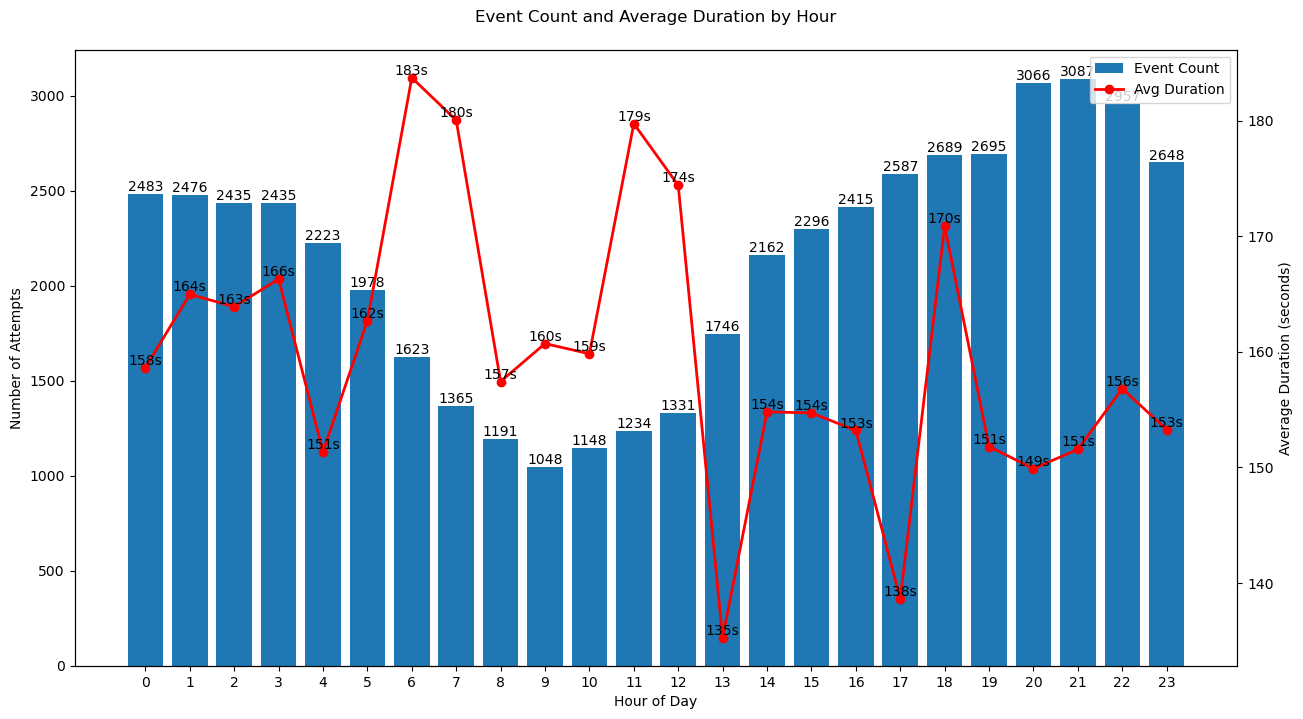

In [ ]:

# analyze the time of day when the most attempts are made and the average duration of the attempts
def analyze_time_info(paths_finished):
    paths_finished['datetime'] = pd.to_datetime(paths_finished['timestamp'], unit='s')
    paths_finished['hour'] = paths_finished['datetime'].dt.hour

    hourly_stats = paths_finished.groupby('hour').agg({
        'timestamp': 'count',  
        'durationInSec': 'mean'  
    }).reset_index()

    fig, ax1 = plt.subplots(figsize=(15, 8))
    bars = ax1.bar(hourly_stats['hour'], hourly_stats['timestamp'], label='Event Count')
    ax2 = ax1.twinx()
    line = ax2.plot(hourly_stats['hour'], hourly_stats['durationInSec'], 
                    color='red', linewidth=2, marker='o', label='Avg Duration')

    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Attempts')

    ax2.set_ylabel('Average Duration (seconds)')

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom')

    for x, y in zip(hourly_stats['hour'], hourly_stats['durationInSec']):
        ax2.text(x, y, f'{int(y)}s', 
                 ha='center', va='bottom')

    plt.title('Event Count and Average Duration by Hour', pad=20)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.xticks(hourly_stats['hour'], rotation=45)

    plt.show()

analyze_time_info(paths_finished)

Maybe there's some bias in the data, but we can tell from the figure people are less likely to play the game in morning and have a hard time in making decisions.

Seems like the morning time is not the best time for gamers, even in this one.

In [ ]:
# 1. calculate the depth of each path based on the common category of the start and end nodes

paths_finished['start_end_depth'] = None  
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')))  

for idx, path in enumerate(paths_finished['path']):
    try:
        articles = path.split(';')
        start_end_category = find_most_detailed_common_category(articles[0], articles[-1])
        depth = len(start_end_category.split('.')) if start_end_category else 0
        paths_finished.loc[paths_finished.index[idx], 'start_end_depth'] = depth
    except Exception as e:
        print(f"Error processing path at index {idx}: {e}")
        continue

# 2. analyze each path node
depth_stats = {}
for depth in sorted(paths_finished['start_end_depth'].unique()):
    # get paths with the current depth
    depth_paths = paths_finished[paths_finished['start_end_depth'] == depth]
    
    # calculate the average depth of each path
    path_avg_depths = []
    for path in depth_paths['path']:
        articles = path.split(';')
        step_depths = []
        
        # calculate the depth between each pair of articles
        for i in range(len(articles) - 1):
            common_category = find_most_detailed_common_category(articles[i], articles[i+1])
            step_depth = len(common_category.split('.')) if common_category else 0
            step_depths.append(step_depth)
        
            path_avg_depths.append(sum(step_depths) / len(step_depths))
    
    depth_stats[depth] = {
        'path_count': len(depth_paths),
        'avg_step_depth': sum(path_avg_depths) / len(path_avg_depths),
        'avg_path_length': depth_paths['path_length'].mean(),
        'avg_duration': depth_paths['durationInSec'].mean(),
        'avg_rating': depth_paths['rating'].mean(),
        'zero_depth_ratio': sum(1 for d in path_avg_depths if d == 0) / len(path_avg_depths)
    }


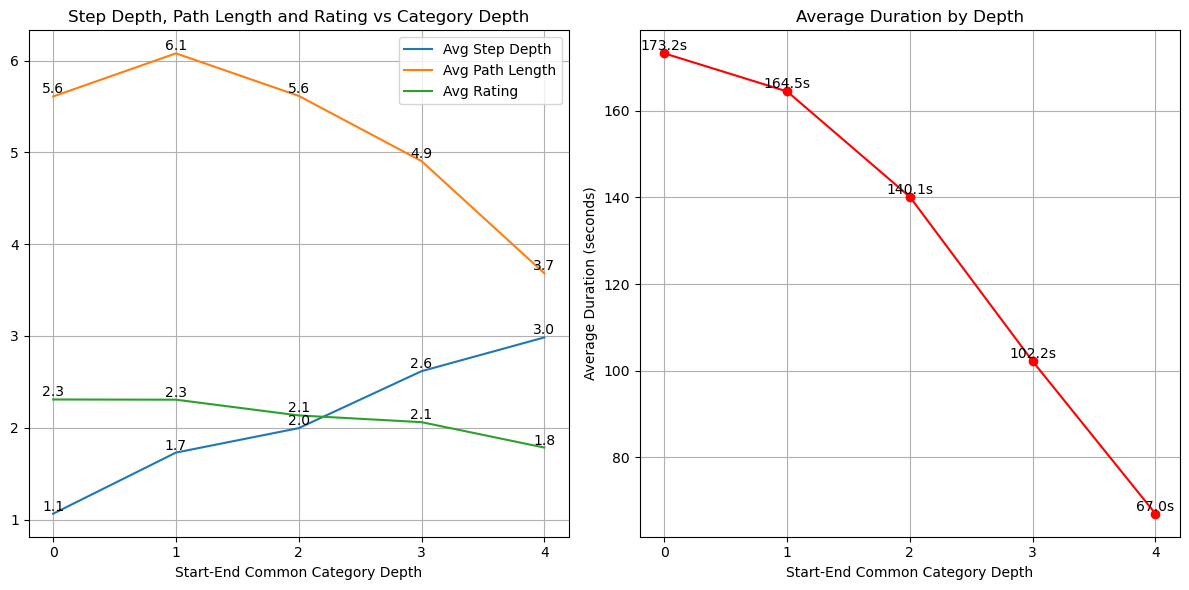

In [ ]:
fig = plt.figure(figsize=(10, 5))
depths = list(depth_stats.keys())

# 1. Average Metrics Trends
ax1 = plt.subplot(1, 2, 1)
metrics = {
    'Avg Step Depth': [depth_stats[d]['avg_step_depth'] for d in depths],
    'Avg Path Length': [depth_stats[d]['avg_path_length'] for d in depths],
    'Avg Rating': [depth_stats[d]['avg_rating'] for d in depths]
}
for label, values in metrics.items():
    ax1.plot(depths, values, label=label)
    for i, value in enumerate(values):
        ax1.text(depths[i], value, f'{value:.1f}', ha='center', va='bottom')
ax1.set_title('Step Depth, Path Length and Rating vs Category Depth')
ax1.set_xlabel('Start-End Common Category Depth')
ax1.set_xticks(depths)  # Set specific x-ticks
ax1.legend()
ax1.grid(True)

# 2. Completion Time Distribution
ax2 = plt.subplot(1, 2, 2)
durations = [depth_stats[d]['avg_duration'] for d in depths]
ax2.plot(depths, durations, marker='o', color='red')
ax2.set_title('Average Duration by Depth')
ax2.set_xlabel('Start-End Common Category Depth')
ax2.set_ylabel('Average Duration (seconds)')
ax2.set_xticks(depths)  # Set specific x-ticks
ax2.grid(True)
# Add value labels
for i, duration in enumerate(durations):
    ax2.text(depths[i], duration, f'{duration:.1f}s', ha='center', va='bottom')


plt.tight_layout()
plt.show()



In [41]:
paths_unfinished = load_and_unquote_paths('data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                                          ['hashedIpAddress','timestamp', 'durationInSec','path','target','type'])
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [42]:
# remove path with only single node
paths_unfinished = paths_unfinished[paths_unfinished['path'].str.contains(';')]
# remove the back navigation
cleaned_paths = []

for path in paths_unfinished['path']:
    nodes = path.split(';')
    stack = []
    
    for node in nodes:
        if node == '<':
            if stack:  
                stack.pop()
        else:
            stack.append(node)
    
    cleaned_path = ';'.join(stack)
    cleaned_paths.append(cleaned_path)

paths_unfinished['path'] = cleaned_paths

paths_unfinished

,hashedIpAddress,timestamp,durationInSec,path,target,type
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout
6,486bb79910fe9dd2,1297101660,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout
7,6d136e371e42474f,1297102070,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart
...,...,...,...,...,...,...
24869,109ed71f571d86e9,1389787212,182,Turks_and_Caicos_Islands;United_States;Iraq;Un...,Iraq_War,restart
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


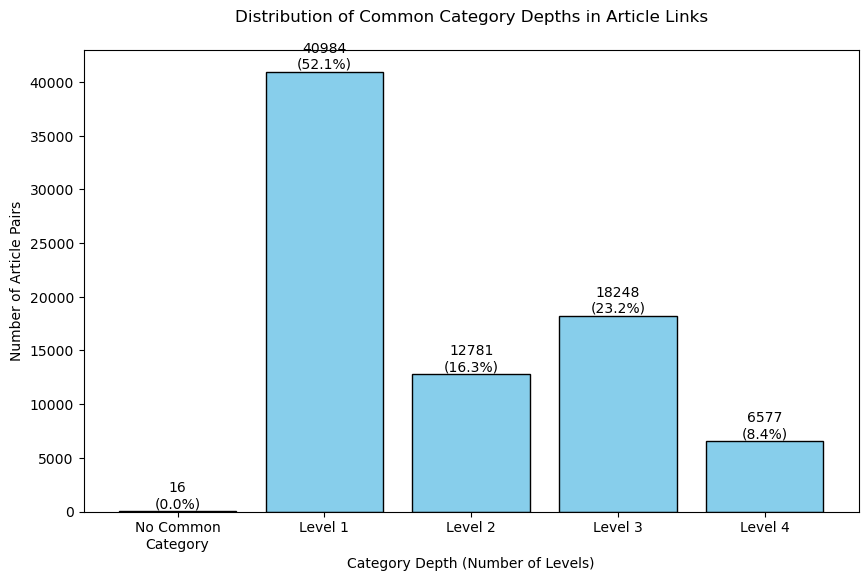

In [43]:
df = pd.DataFrame(columns=['from', 'to'])
rows = []
for path in paths_unfinished['path']:
    nodes = path.split(';')
    for i in range(len(nodes) - 1):
        rows.append({'from': nodes[i], 'to': nodes[i + 1]})

df = pd.DataFrame(rows)

plot_category_depth_distribution(analyze_category_depths(df))

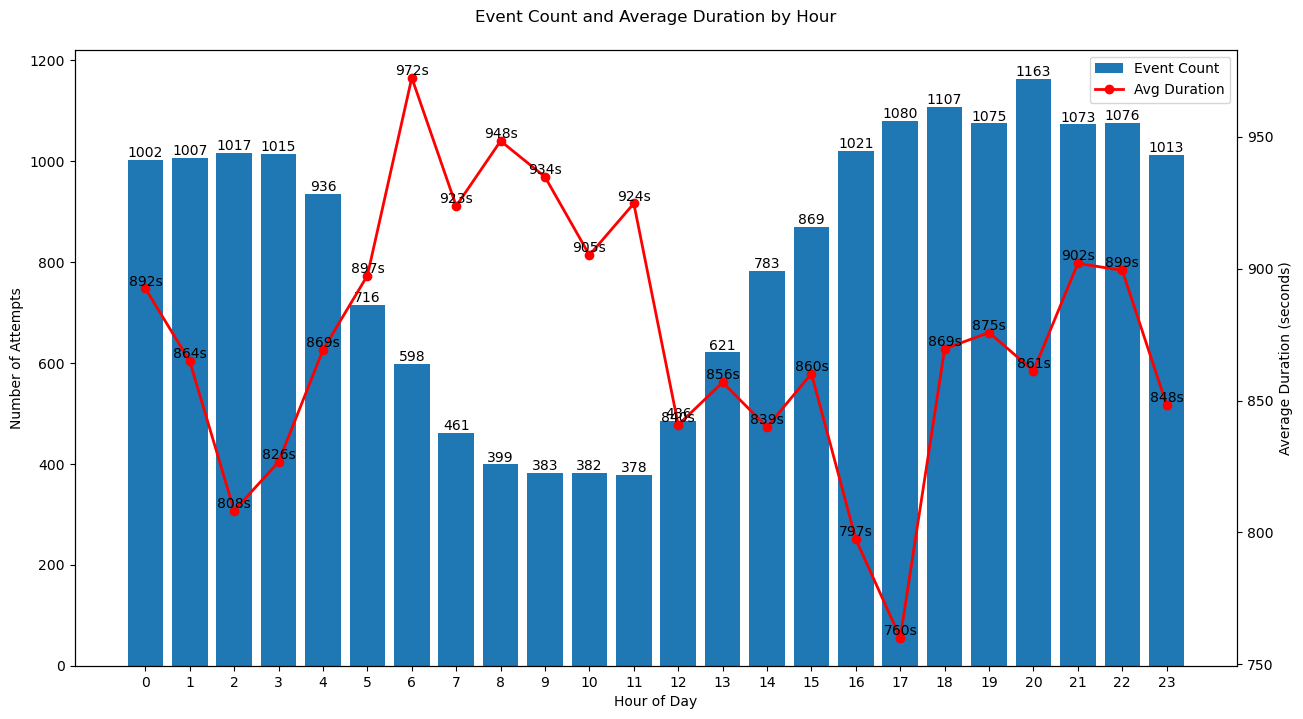

In [44]:
analyze_time_info(paths_unfinished)

In [45]:
with open('data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt', 'r') as file:
    data = file.readlines()
# remove comment 
data = [line.strip() for line in data if not line.startswith('#') and line.strip()]
# convert the data into a matrix
distance_matrix = [list(line) for line in data]
# convert the matrix into a DataFrame
df = pd.DataFrame(distance_matrix)
df.replace('_', pd.NA, inplace=True)
df = df.apply(pd.to_numeric)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4594,4595,4596,4597,4598,4599,4600,4601,4602,4603
0,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
1,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
2,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
3,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
4,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


Mean shortest-path distance: 3.201729547596255
Median shortest-path distance: 3.0


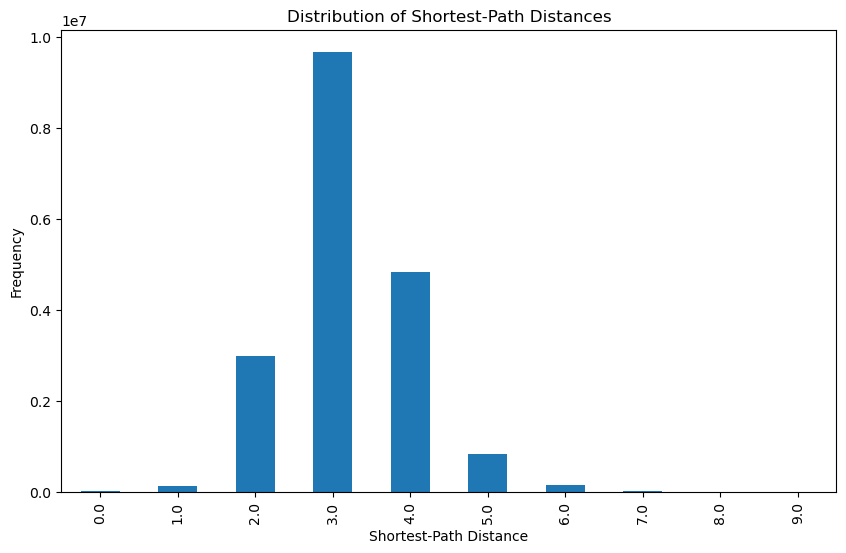

In [46]:
import matplotlib.pyplot as plt

mean_distance = df.stack().mean()
median_distance = df.stack().median()
distance_distribution = df.stack().value_counts().sort_index()

print(f"Mean shortest-path distance: {mean_distance}")
print(f"Median shortest-path distance: {median_distance}")

plt.figure(figsize=(10, 6))
distance_distribution.plot(kind='bar')
plt.title('Distribution of Shortest-Path Distances')
plt.xlabel('Shortest-Path Distance')
plt.ylabel('Frequency')
plt.show()